# Proof of Concept: Generic Black-box VI on an Unnormalized Distribution

Recall that the objective of variational inference is to maximize the Evidence Lower Bound (ELBO), defined as
$$\mathcal{L}(\lambda)=\mathbb{E}_{q_{\lambda}(z)}[\log p(x,z)-\log q_{\lambda}(z)] = \mathbb{E}_{q_{\lambda}(z)}[\log p(x,z)]-\mathbb{E}_{q_{\lambda}(z)}[\log q_{\lambda}(z)]$$

In Black-box Variational Inference, we want to maximize this ELBO using stochastic gradient descent. To do this, we derive the derivative of the ELBO and introduce the Monte Carlo approximation of this derivative
\begin{align*}
\nabla_{\lambda}\mathcal{L}(\lambda)&=\mathbb{E}_{q_{\lambda}(z)}[\nabla_{\lambda} \log q_{\lambda}(z)(\log p(x,z)-\log q_{\lambda}(z))]\\
&\approx \frac{1}{S} \sum_{s=1}^S [\nabla_{\lambda} \log q_{\lambda}(z)(\log p(x,z)-\log q_{\lambda}(z))]
\end{align*}

The following function implements VI automatically by approximating the ELBO using $\mathbb{E}_{q_{\lambda}(z)}[\log p(x,z)]-\mathbb{E}_{q_{\lambda}(z)}[\log q_{\lambda}(z)]$. It uses a multivariate Gaussian with a diagonal covariance matrix as its approximating distribution. The second term $\mathbb{E}_{q_{\lambda}(z)}[\log q_{\lambda}(z)]$ can be calculated exactly for this approximating distribution. To estimate the first term, we use a Monte Carlo estimate that's augmented with the reparameterization trick. The Monte Carlo estimate of the first term is
$$\mathbb{E}_{q_{\lambda}(z)}[\log p(x,z)] \approx \frac{1}{S} \sum_{s=1}^S p(x, z_s) \text{ where } z \sim q_{\lambda}(z) $$ Therefore, we simply sample $z$ from the variational distribution $q$ and then compute the log density of the model. The reparameterization trick allows us to backpropagate through the random node $z$ to arrive at the gradients with respect to `mu` and `cov` which $z$ depends on. In its current formulation, $z$ is a random variable that depends on `mu` and `cov` which makes finding the gradient with respect to these parameters very difficult. To do this, we use a new variable $\epsilon$ whose distribution is the standard normal $N(0, 1)$ and turn $z$ into a deterministic function of `mu` and `cov` (given the value of $\epsilon$).

The `autograd` package in python is very powerful as it gives us a way to simply differentiate with respect to the parameters and perform gradient ascent.

In [251]:
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt

import autograd
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.multivariate_normal as mvn
import autograd.scipy.stats.norm as norm

from autograd import grad
from autograd.misc.optimizers import adam


def black_box_variational_inference_diagonal(logprob, D, num_samples):
    """Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557
    
    variational_params: the mean and covariance of approximate posterior.
    logprob_func: the unnormalized log-probability of the model.
    D: the number of parameters in the model.
    num_samples: the number of Monte Carlo samples to use.
    """
    
    # Unpack mean and covariance of diagonal Gaussian.
    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    # Sample from multivariate normal using the reparameterization trick.
    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)
    
    # Lower bound is the exact entropy plus a Monte Carlo estimate of energy.
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params




    

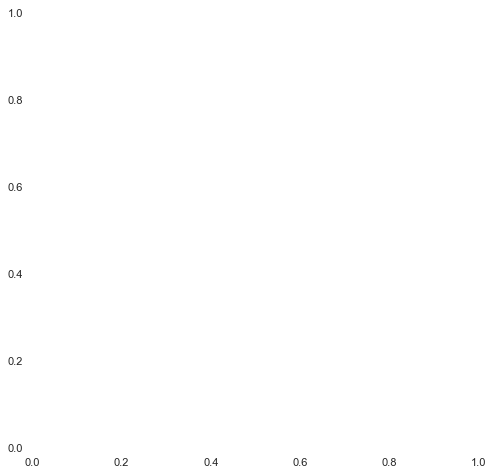

Optimizing variational parameters...
Iteration 0 lower bound -15.241833539889583


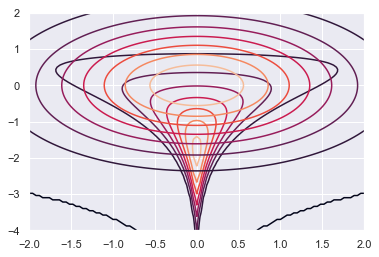

Iteration 0 lower bound -3.1954904550812824


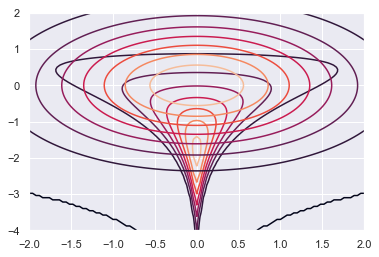

Iteration 50 lower bound -0.4591890621407715


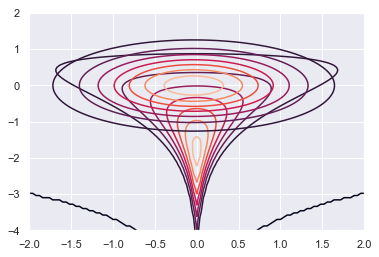

Iteration 100 lower bound -1.1942496694405174


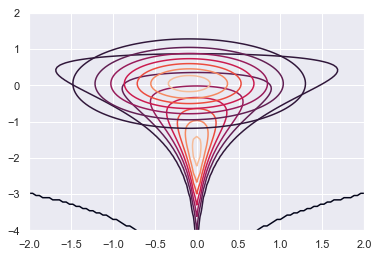

Iteration 150 lower bound -0.3166989612040845


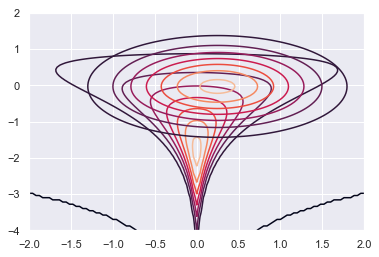

Iteration 200 lower bound -1.4889290917902247


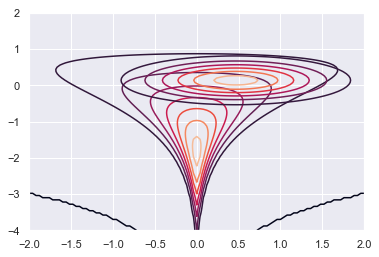

Iteration 250 lower bound -1.1722667113296426


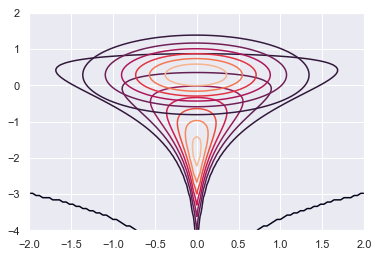

Iteration 300 lower bound -0.9371375158350972


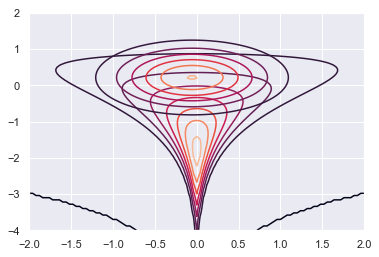

Iteration 350 lower bound -3.2099672716349907


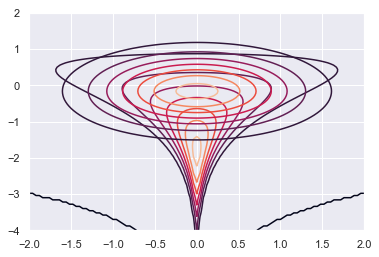

Iteration 400 lower bound -1.0184678386008246


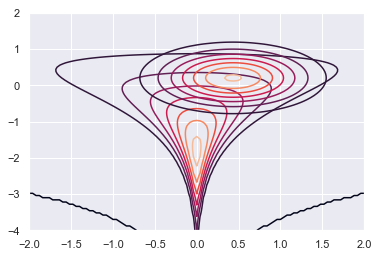

Iteration 450 lower bound -0.6172626281446183


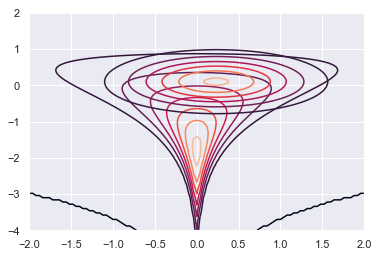

Iteration 500 lower bound -0.7923451176124536


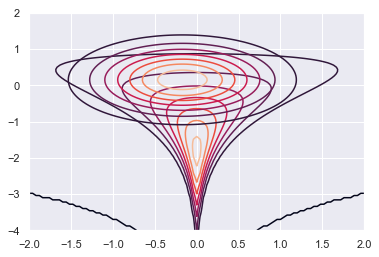

Iteration 550 lower bound -0.772208392358823


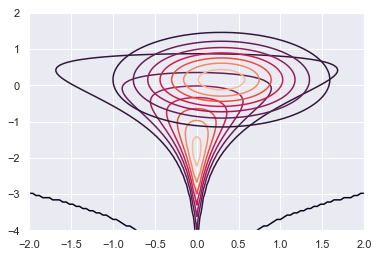

Iteration 600 lower bound -0.7031131307342366


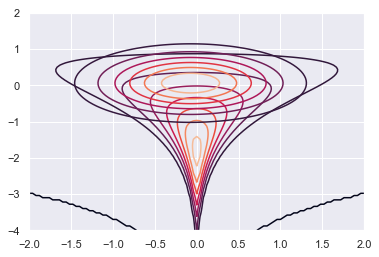

Iteration 650 lower bound -0.5886871050795026


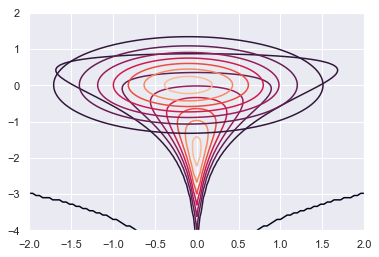

Iteration 700 lower bound -1.8153073280066105


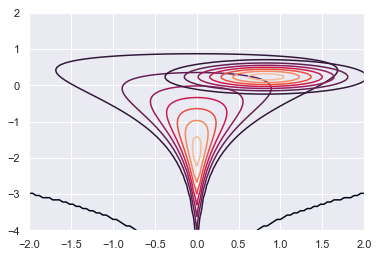

Iteration 750 lower bound -0.9119432098275926


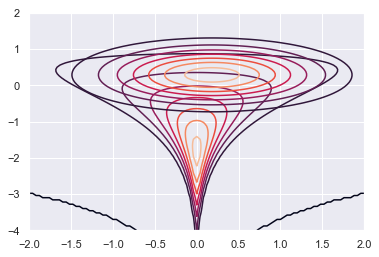

Iteration 800 lower bound -0.41480752628186845


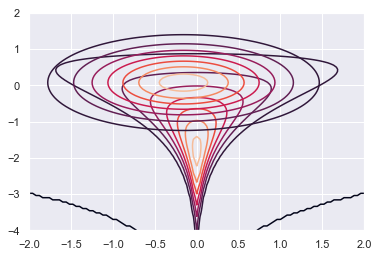

Iteration 850 lower bound -0.5456601402607131


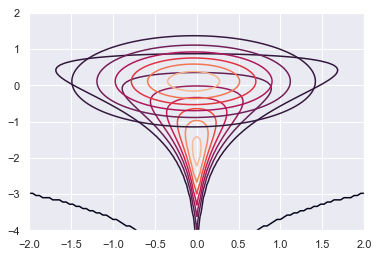

Iteration 900 lower bound -0.17747437216328343


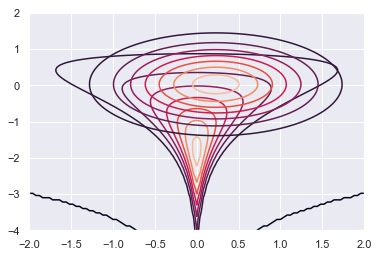

Iteration 950 lower bound -1.05454076533826


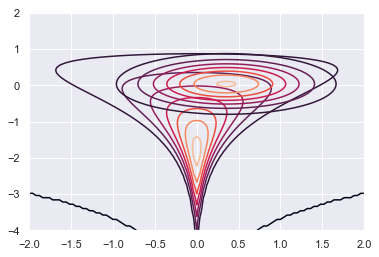

Iteration 1000 lower bound -1.0246000936279218


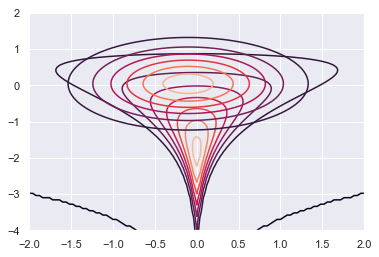

Iteration 1050 lower bound -1.0361424134214374


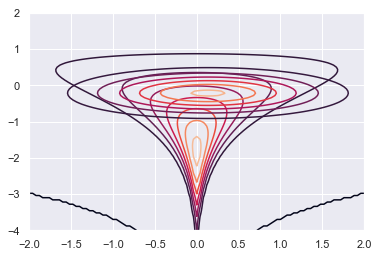

Iteration 1100 lower bound -0.7263332026828224


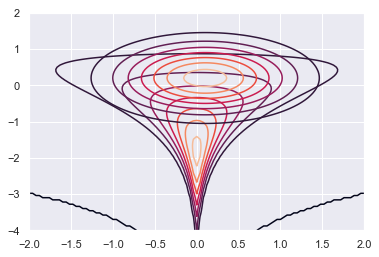

Iteration 1150 lower bound -0.9215264236280905


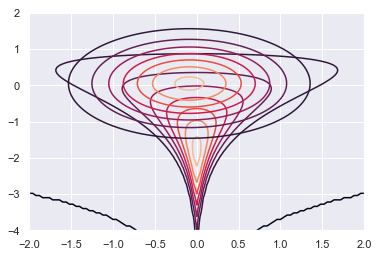

Iteration 1200 lower bound -0.48554136918860946


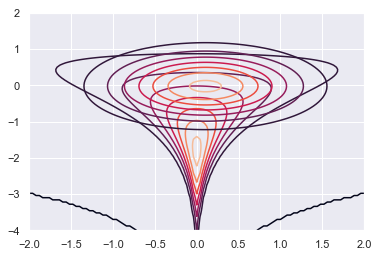

Iteration 1250 lower bound -0.39225428004054175


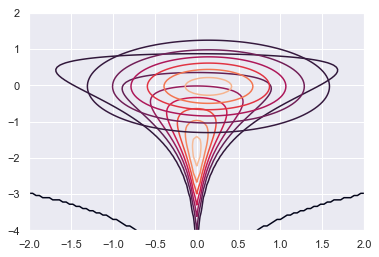

Iteration 1300 lower bound -0.34480053858782567


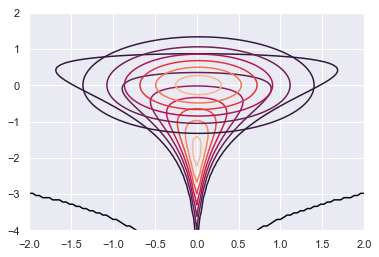

Iteration 1350 lower bound -0.9056408697877041


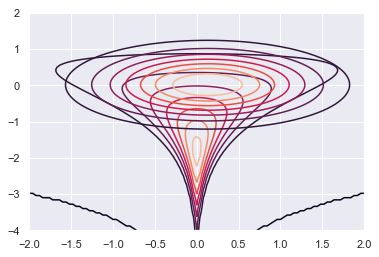

Iteration 1400 lower bound -0.4581149087074534


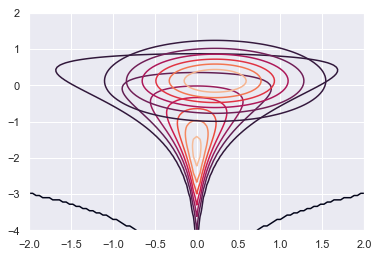

Iteration 1450 lower bound -1.0696686100377912


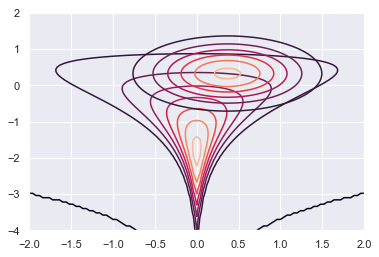

Iteration 1500 lower bound -1.2479713549947453


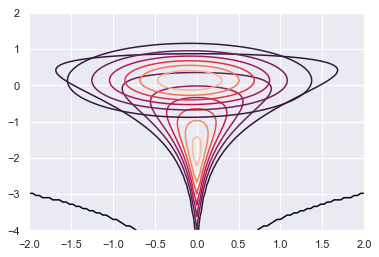

Iteration 1550 lower bound -0.38758121909734533


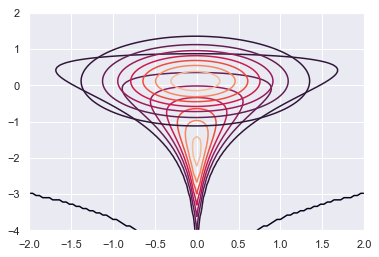

Iteration 1600 lower bound -0.5915097468041797


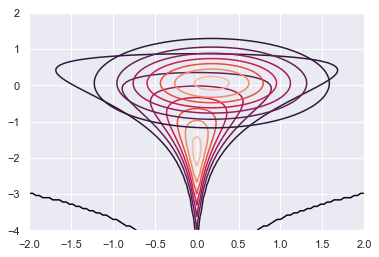

Iteration 1650 lower bound -2.189133938660101


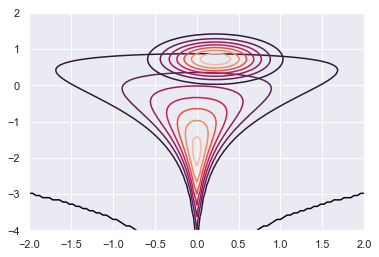

Iteration 1700 lower bound -0.44972769743693286


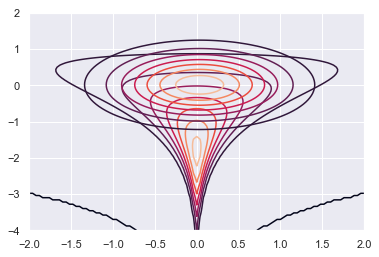

Iteration 1750 lower bound -0.996964928826783


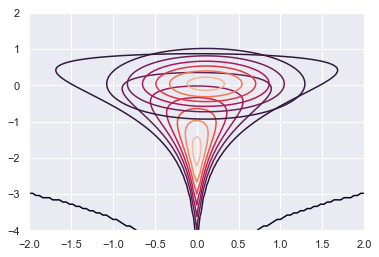

Iteration 1800 lower bound -0.9501842521745996


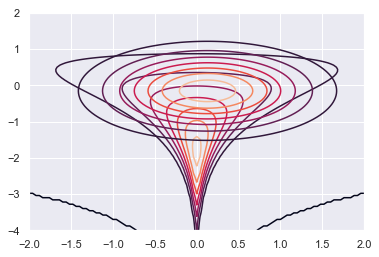

Iteration 1850 lower bound -0.9253304744416255


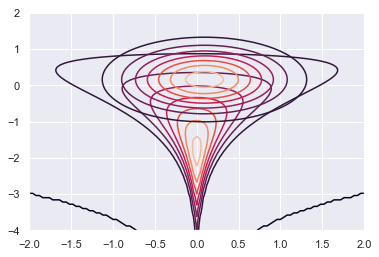

Iteration 1900 lower bound -0.3693758626020953


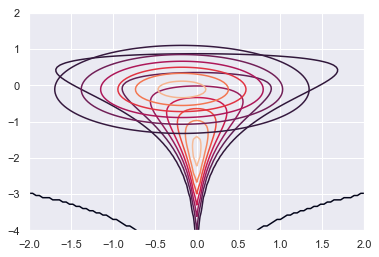

Iteration 1950 lower bound -1.8299935092021364


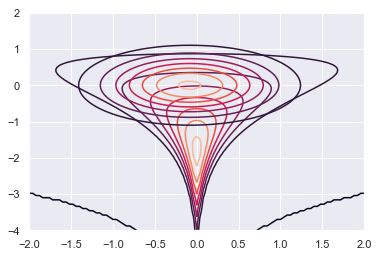

In [252]:
# Specify an inference problem by its unnormalized log-density.
D = 2
def log_density(x, t):
    mu, log_sigma = x[:, 0], x[:, 1]
    sigma_density = norm.logpdf(log_sigma, 0, 1.35)
    mu_density = norm.logpdf(mu, 0, np.exp(log_sigma))
    return sigma_density + mu_density

# Build variational objective.
objective, gradient, unpack_params = \
    black_box_variational_inference_diagonal(log_density, D, num_samples=10)

# Set up plotting code
def plot_isocontours(ax, func, xlimits=[-2, 2], ylimits=[-4, 2], numticks=101):
    x = np.linspace(*xlimits, num=numticks)
    y = np.linspace(*ylimits, num=numticks)
    X, Y = np.meshgrid(x, y)
    zs = func(np.concatenate([np.atleast_2d(X.ravel()), np.atleast_2d(Y.ravel())]).T)
    Z = zs.reshape(X.shape)
    plt.contour(X, Y, Z)
    ax.set_yticks([])
    ax.set_xticks([])

# Set up figure.
fig = plt.figure(figsize=(8,8), facecolor='white')
ax = fig.add_subplot(111, frameon=False)
plt.ion()
plt.show(block=False)

def callback(params, t, g):
    if t % 50 == 0:
        print("Iteration {} lower bound {}".format(t, -objective(params, t)))
        plt.cla()
        target_distribution = lambda x : np.exp(log_density(x, t))
        plot_isocontours(ax, target_distribution)

        mean, log_std = unpack_params(params)
        variational_contour = lambda x: mvn.pdf(x, mean, np.diag(np.exp(2*log_std)))
        plot_isocontours(ax, variational_contour)
        plt.draw()
        plt.pause(1.0/30.0)


print("Optimizing variational parameters...")
init_mean    = 0 * np.ones(D)
init_log_std = np.array([0.15,0.15])
init_var_params = np.concatenate([init_mean, init_log_std])
objective(init_var_params, 1)
callback(init_var_params, 0, 1)
variational_params = adam(gradient, init_var_params, step_size=0.1, num_iters=2000, callback=callback)

The previous code implemented a Gaussian variational approximation to the distribution using a diagonal covariance. However, this does not capture some of the interdependencies between the parameters. To improve upon the approximation, I will attempt to use a full-rank covariance matrix. To make parametrization easy, I use the Cholesky decomposition of the covariance matrix as my parameter. However, it appears that the ELHO of my data after optimization isn't that high (-150 compared to -0.5 in the diagonal case), which might show that optimization with a full-rank matrix is hard and we might as well stick to the mean-field case. Furthermore, the optimized covariance matrix ends up looking close to diagonal anyway, even though it takes much longer to converge to this solution.

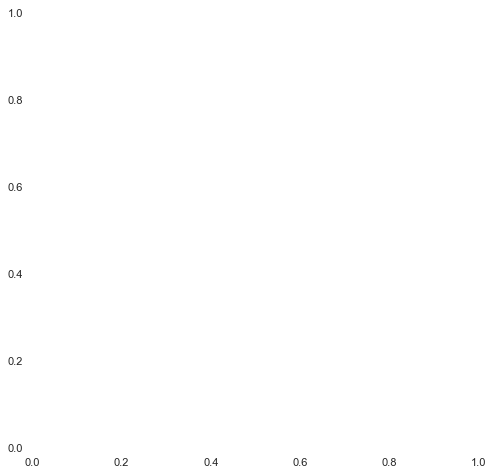

Optimizing variational parameters...
Iteration 0 lower bound -229935587.54788566


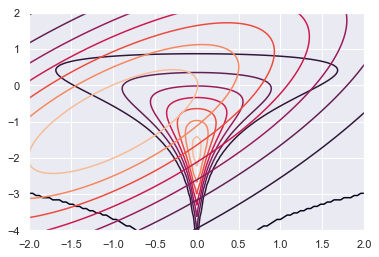

Iteration 500 lower bound -200.70561353424824


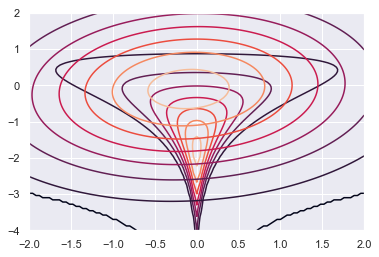

Iteration 1000 lower bound -132.06456072652182


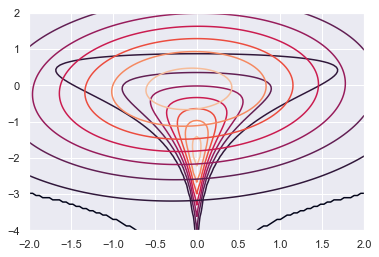

Iteration 1500 lower bound -162.2590355370733


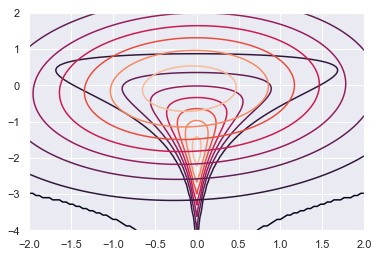

Iteration 2000 lower bound -95.8875164418002


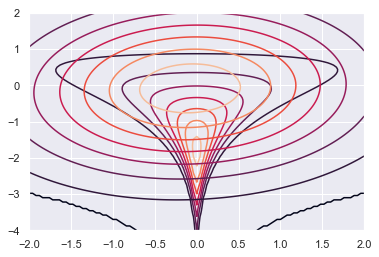

Iteration 2500 lower bound -68.40817233100238


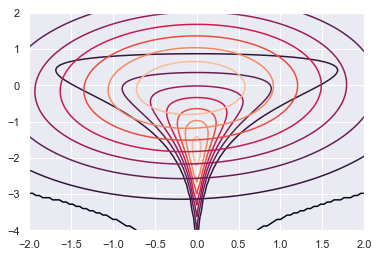

Iteration 3000 lower bound -71.37447484384829


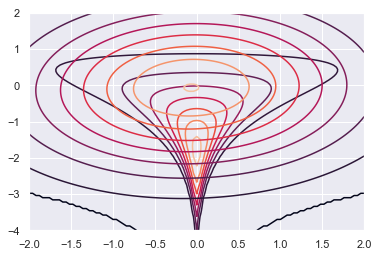

Iteration 3500 lower bound -107.79233908305197


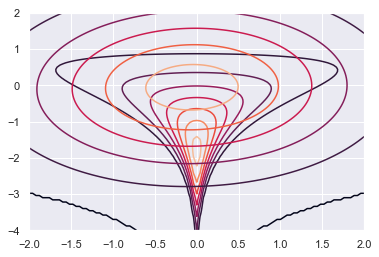

Iteration 4000 lower bound -60.899643423417196


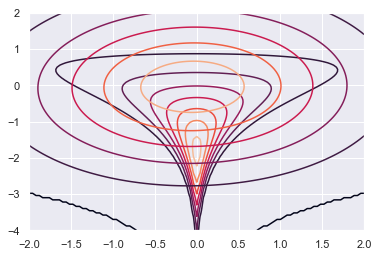

Iteration 4500 lower bound -50.01338686361336


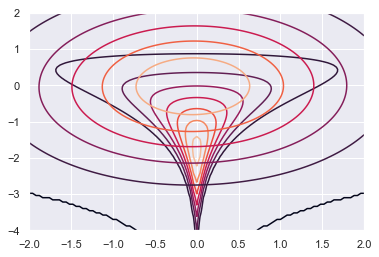

Iteration 5000 lower bound -55.3675193201269


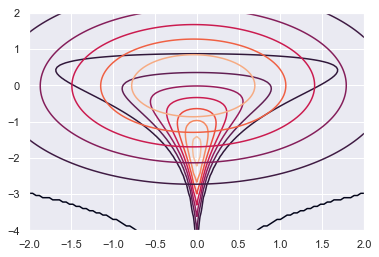

Iteration 5500 lower bound -39.49605504296677


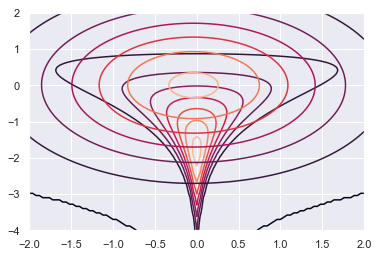

Iteration 6000 lower bound -36.57953855124235


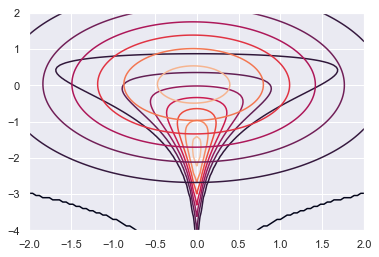

Iteration 6500 lower bound -18.46949263807389


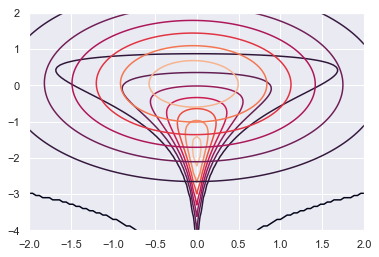

Iteration 7000 lower bound -13.635670883637896


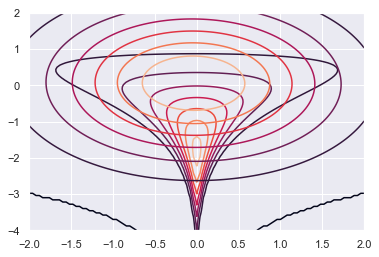

Iteration 7500 lower bound -13.827791623314264


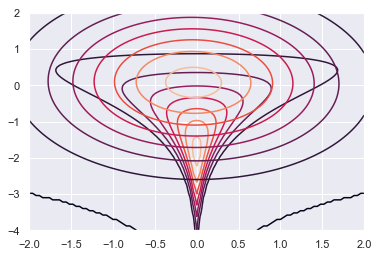

Iteration 8000 lower bound -9.331330101988492


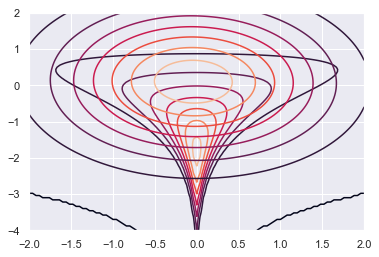

Iteration 8500 lower bound -7.428577631523638


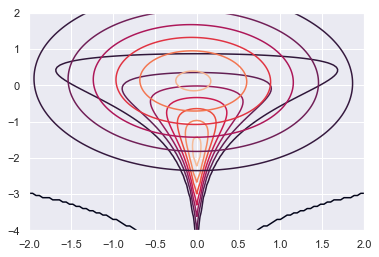

Iteration 9000 lower bound -7.260509804382702


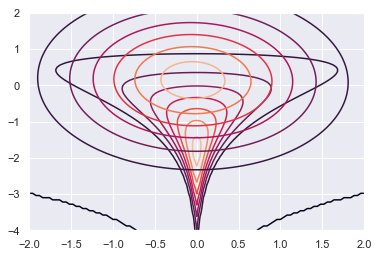

Iteration 9500 lower bound -4.754609470200272


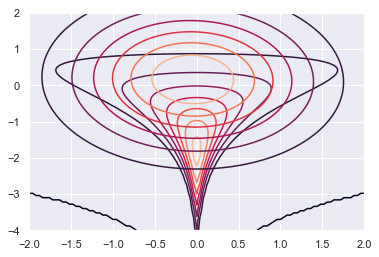

Iteration 10000 lower bound -3.740779750883588


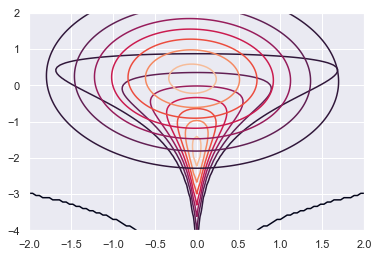

Iteration 10500 lower bound -10.258715187528544


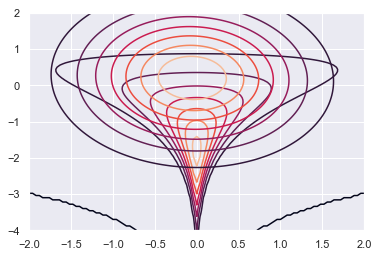

Iteration 11000 lower bound -2.7612211284819375


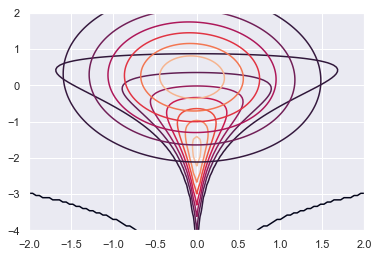

Iteration 11500 lower bound -2.7738854285290695


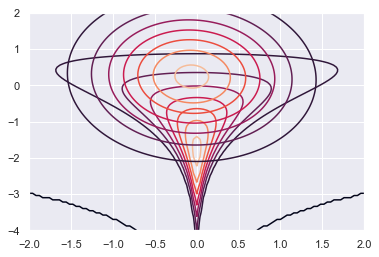

Iteration 12000 lower bound -2.3075414424205913


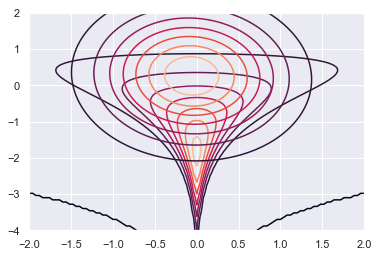

Iteration 12500 lower bound -1.9271418678378556


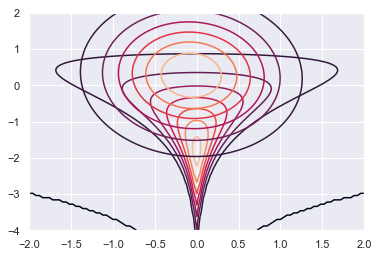

Iteration 13000 lower bound -1.727435734177221


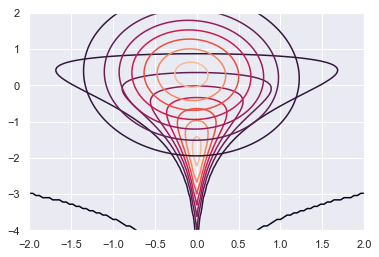

Iteration 13500 lower bound -1.4988834255934522


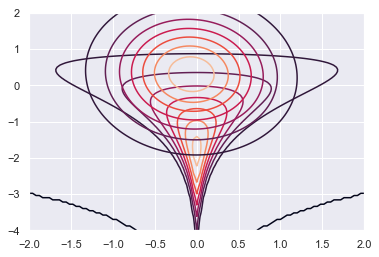

Iteration 14000 lower bound -1.3170462672198289


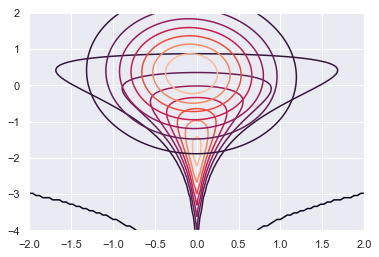

Iteration 14500 lower bound -1.1817522744848854


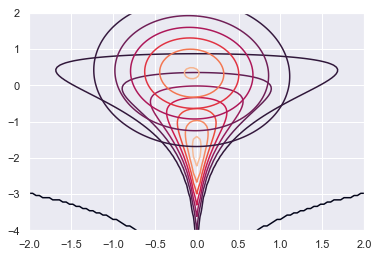

Iteration 15000 lower bound -1.1554213371867852


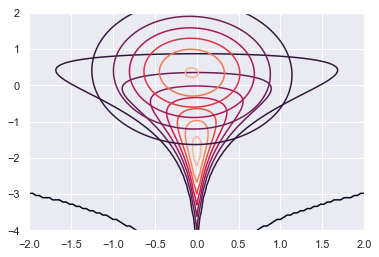

Iteration 15500 lower bound -1.080653457614614


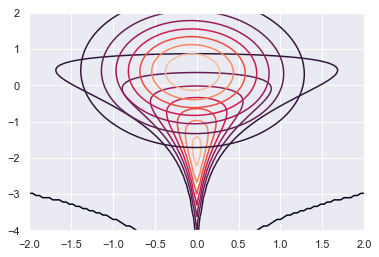

Iteration 16000 lower bound -1.01859717182072


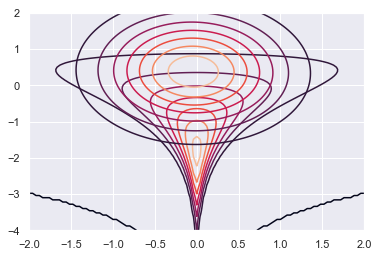

Iteration 16500 lower bound -0.9383785490662406


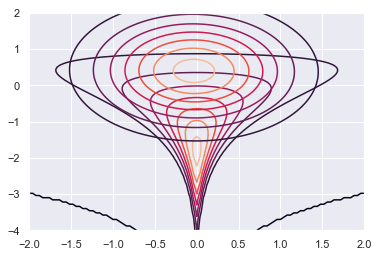

Iteration 17000 lower bound -0.9001586793146981


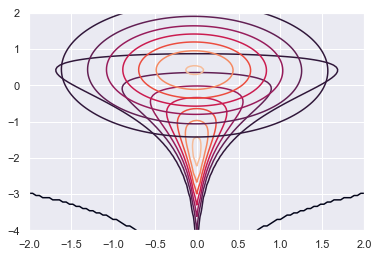

Iteration 17500 lower bound -0.7528820176677304


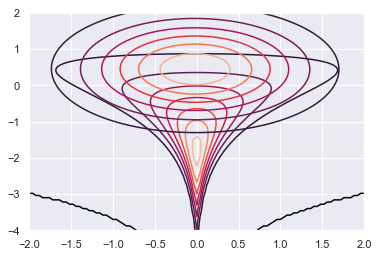

Iteration 18000 lower bound -0.7225334958238201


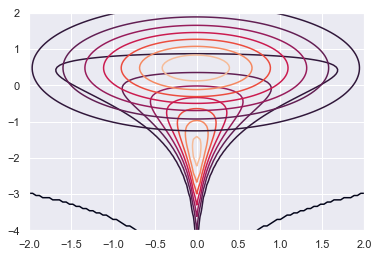

Iteration 18500 lower bound -0.600213456322273


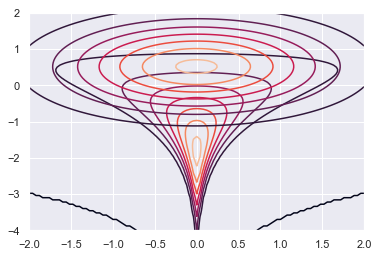

Iteration 19000 lower bound -0.5173757314736078


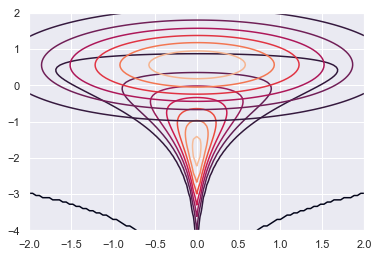

Iteration 19500 lower bound -0.5028778327558454


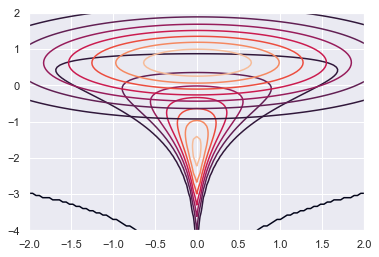

In [254]:
def black_box_variational_inference_full_rank(logprob, D, num_samples):
    """Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557
    
    variational_params: the mean and covariance of approximate posterior.
    logprob_func: the unnormalized log-probability of the model.
    D: the number of parameters in the model.
    num_samples: the number of Monte Carlo samples to use.
    """
    
    # Unpack mean and covariance of diagonal Gaussian.
    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, cholesky = params[:,0],params[:,1:]
        return mean, cholesky

    # Sample from multivariate normal using the reparameterization trick.
    def gaussian_entropy(cholesky):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + 0.5 + np.log(np.linalg.det(cholesky.__rmatmul__(cholesky.T)))

    rs = npr.RandomState(0)
    
    # Lower bound is the exact entropy plus a Monte Carlo estimate of energy.
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, cholesky = unpack_params(params)
        samples = (cholesky).__rmatmul__(rs.randn(num_samples, D)) + mean
        lower_bound = gaussian_entropy(cholesky) + np.mean(logprob(samples, t))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params


# Specify an inference problem by its unnormalized log-density.
D = 2
def log_density(x, t):
    mu, log_sigma = x[:, 0], x[:, 1]
    sigma_density = norm.logpdf(log_sigma, 0, 1.35)
    mu_density = norm.logpdf(mu, 0, np.exp(log_sigma))
    return sigma_density + mu_density

# Build variational objective.
objective, gradient, unpack_params = \
    black_box_variational_inference_full_rank(log_density, D, num_samples=10000)

# Set up plotting code
def plot_isocontours(ax, func, xlimits=[-2, 2], ylimits=[-4, 2], numticks=101):
    x = np.linspace(*xlimits, num=numticks)
    y = np.linspace(*ylimits, num=numticks)
    X, Y = np.meshgrid(x, y)
    zs = func(np.concatenate([np.atleast_2d(X.ravel()), np.atleast_2d(Y.ravel())]).T)
    Z = zs.reshape(X.shape)
    plt.contour(X, Y, Z)
    ax.set_yticks([])
    ax.set_xticks([])

# Set up figure.
fig = plt.figure(figsize=(8,8), facecolor='white')
ax = fig.add_subplot(111, frameon=False)
plt.ion()
plt.show(block=False)

def callback(params, t, g):
    if t % 500 == 0:
        print("Iteration {} lower bound {}".format(t, -objective(params, t)))
        plt.cla()
        target_distribution = lambda x : np.exp(log_density(x, t))
        plot_isocontours(ax, target_distribution)

        mean, cholesky = unpack_params(params)
        variational_contour = lambda x: mvn.pdf(x, mean, cholesky.__rmatmul__(cholesky.T))
        plot_isocontours(ax, variational_contour)
        plt.show()


print("Optimizing variational parameters...")
init_mean    = -np.ones((D,1))
init_cholesky = np.triu(2 * np.ones((D,D)))
init_var_params = np.hstack((init_mean, init_cholesky))
unpack_params(init_var_params)
variational_params = adam(gradient, init_var_params, step_size=0.1, num_iters=20000, callback=callback)
    

# Variational Inference in a Neural Network for Regression

Here I will demonstrate how VI works on a neural network for regression. The `make_nn_funs` implements a radial basis function network that maps the input from 1-dimensional space into a continuous output (regression). The neural network has 2 hidden layers, each with 20 units. Therefore, we have 481 parameters for the model, because the first layer has 40 parameters (20 units, each with a weight to deal with the input and the bias term), the second layer has 420 parameters (20 units, each with 20 weights to deal with all outputs from the previous layer's 20 units and the bias term), and the output layer has 21 parameters (20 weights to deal with all outputs from the previous layer's 20 units and a bias term). For a Bayesian neural network, we put a prior on the weights, which comes from the normal prior with fixed variance (representing the regularization term), and the likelihood comes from the log of the Gaussian distribution, whose mean is the result of the forward propagation of the neural network, and whose variance is fixed as a hyperparameter. Since we have a mean-field approximation, there will be 481 means and 481 standard deviations as variational parameters. 

The ELBO is again composed of 2 terms: the entropy and the cross-entropy. The `black_box_variational_inference_diagonal` provides a gradient to this ELBO, which is then optimized by autograd. Then, to sample a posterior predictive distribution, we sample neural network weights from the approximate (variational) posterior and use the sampled weights to produce a posterior predictive distribution given new input. Interestingly, the posterior predictive distribution looks remarkably like that of a Gaussian process: interpolation gives tight bounds (capturing some notion of smoothness) while extrapolation gives diverging results. I have previously read in the literature that deep neural networks can be conceptualized as Gaussian processes, so this gives an exciting link to that literature [1]

In [253]:
import copy 
def make_nn_funs(layer_sizes, L2_reg, noise_variance, nonlinearity=np.tanh):
    """These functions implement a standard multi-layer perceptron,
    vectorized over both training examples and weight samples."""
    shapes = list(zip(layer_sizes[:-1], layer_sizes[1:])) # define tensor shapes
    num_weights = sum((m+1)*n for m, n in shapes) # weights + bias term
    print(num_weights, shapes, [(m+1)*n for m, n in shapes])

    def unpack_layers(weights):
        num_weight_sets = len(weights)
        for m, n in shapes:
            yield weights[:, :m*n]     .reshape((num_weight_sets, m, n)),\
                  weights[:, m*n:m*n+n].reshape((num_weight_sets, 1, n))
            weights = weights[:, (m+1)*n:]

    def predictions(weights, inputs):
        """weights is shape (num_weight_samples x num_weights)
           inputs  is shape (num_datapoints x D)"""
        inputs = np.expand_dims(inputs, 0)
        for W, b in unpack_layers(weights):
            outputs = np.einsum('mnd,mdo->mno', inputs, W) + b
            inputs = nonlinearity(outputs)
        return outputs

    def logprob(weights, inputs, targets):
        log_prior = -L2_reg * np.sum(weights**2, axis=1)
        preds = predictions(weights, inputs)
        log_lik = -np.sum((preds - targets)**2, axis=1)[:, 0] / noise_variance
        return log_prior + log_lik

    return num_weights, predictions, logprob


def build_toy_dataset(n_data=40, noise_std=0.1):
    D = 1
    rs = npr.RandomState(0)
    inputs  = np.concatenate([np.linspace(0, 2, num=n_data/2),
                              np.linspace(6, 8, num=n_data/2)])
    targets = np.cos(inputs) + rs.randn(n_data) * noise_std
    inputs = (inputs - 4.0) / 4.0
    inputs  = inputs.reshape((len(inputs), D))
    targets = targets.reshape((len(targets), D))
    return inputs, targets



    

141 [(1, 10), (10, 10), (10, 1)] [20, 110, 11]
Optimizing variational parameters...
Iteration 0 lower bound -38775.18427703714


<Figure size 864x576 with 0 Axes>

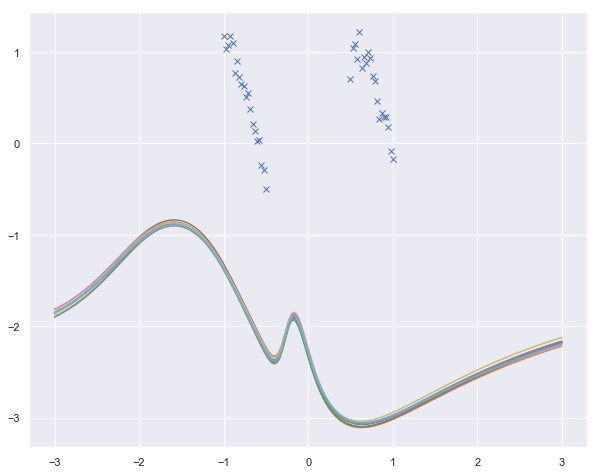

Iteration 50 lower bound -462.8322686783978


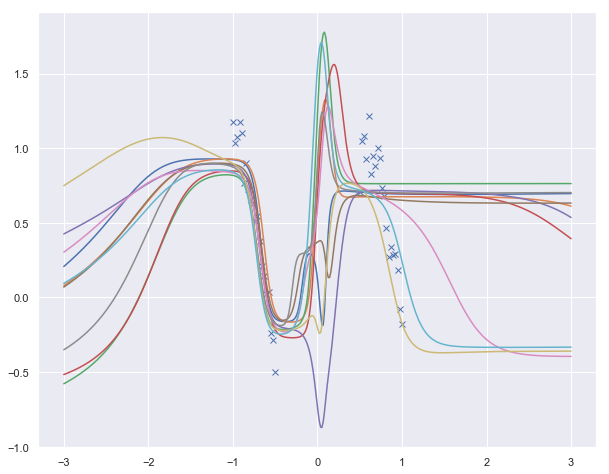

Iteration 100 lower bound -195.8638746552716


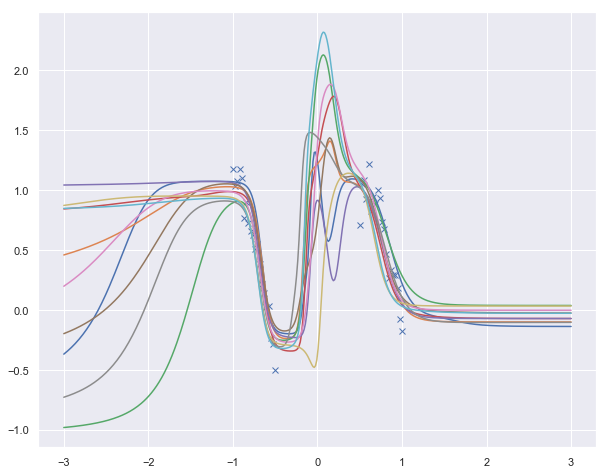

Iteration 150 lower bound -129.54461720422978


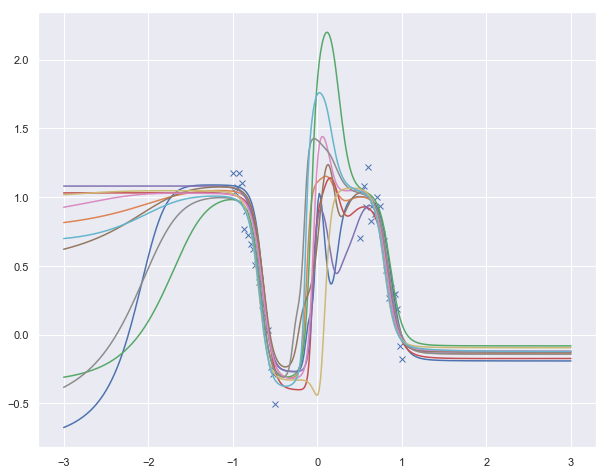

Iteration 200 lower bound -128.4675039000731


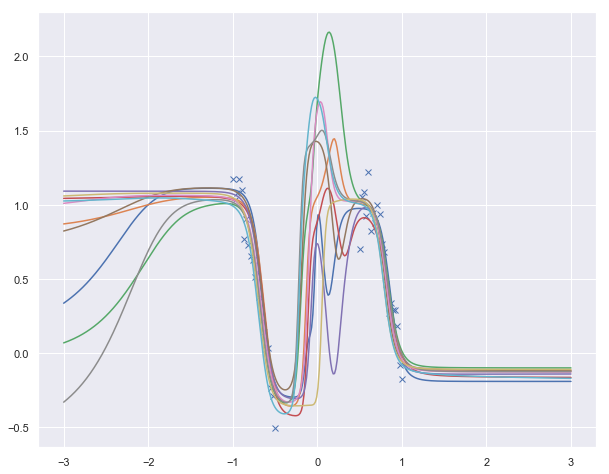

Iteration 250 lower bound -118.6865957167945


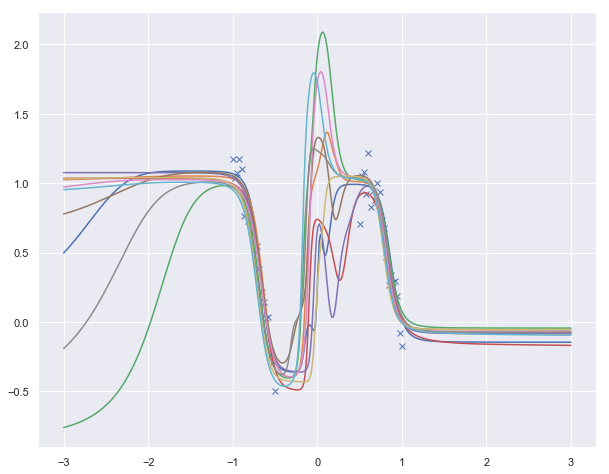

Iteration 300 lower bound -117.73301050014425


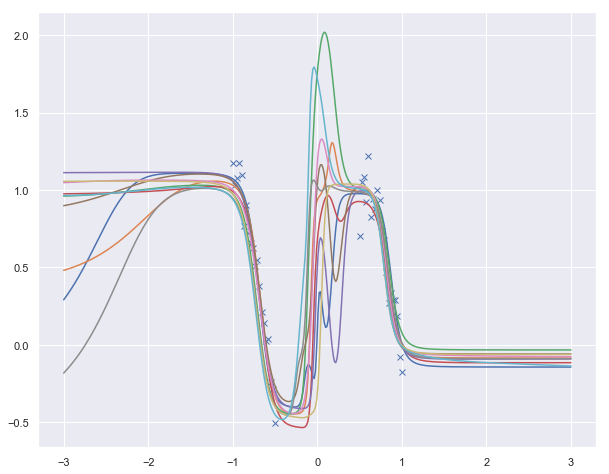

Iteration 350 lower bound -141.9481641659826


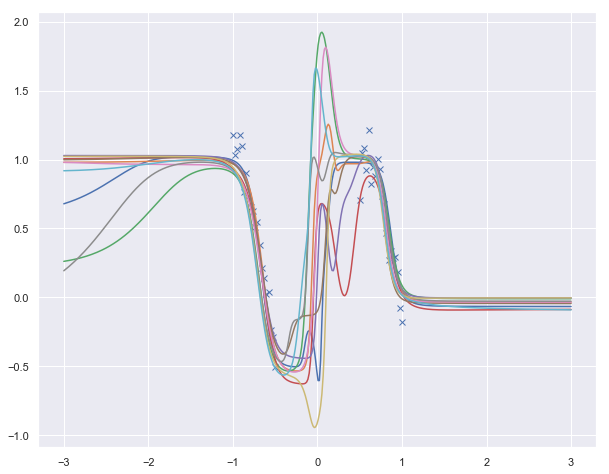

Iteration 400 lower bound -100.38388143663764


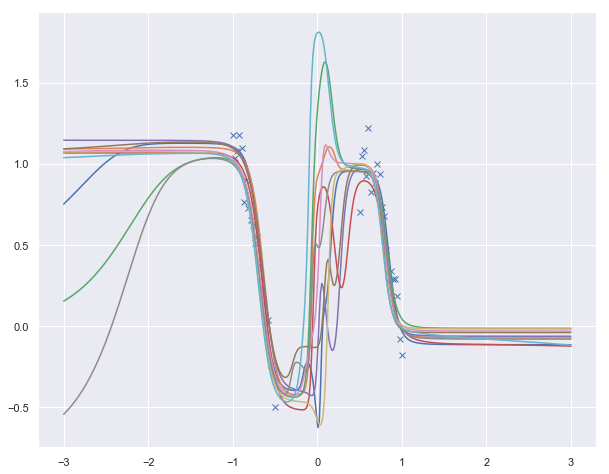

Iteration 450 lower bound -99.06962428330527


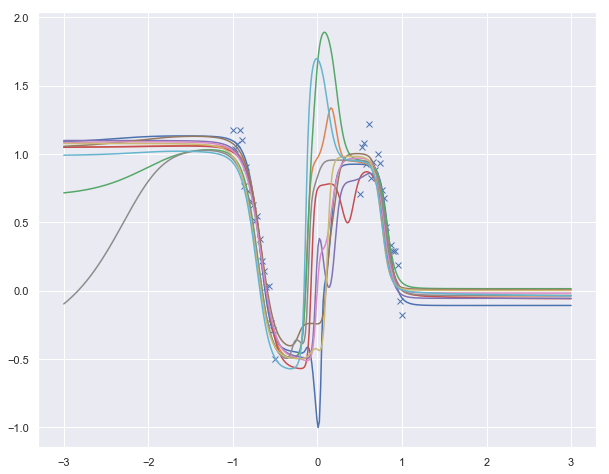

In [109]:
# Specify inference problem by its unnormalized log-posterior.
rbf = lambda x: np.exp(-x**2)
relu = lambda x: np.maximum(x, 0.)
num_weights, predictions, logprob = \
    make_nn_funs(layer_sizes=[1, 10, 10, 1], L2_reg=0.1,
                 noise_variance=0.01, nonlinearity=np.tanh)

inputs, targets = build_toy_dataset()
log_posterior = lambda weights, t: logprob(weights, inputs, targets)

# Build variational objective.
objective, gradient, unpack_params = \
    black_box_variational_inference_diagonal(log_posterior, num_weights,
                                    num_samples=20)

# Set up figure.
fig = plt.figure(figsize=(12, 8), facecolor='white')
# ax = fig.add_subplot(111, frameon=False)
# plt.ion()


def callback(params, t, g, inputs=inputs, targets=targets, ax=ax):
    if t % 50 == 0:
        print("Iteration {} lower bound {}".format(t, -objective(params, t)))

        # Sample functions from posterior.
        rs = npr.RandomState(0)
        mean, log_std = unpack_params(params)
        #rs = npr.RandomState(0)
        sample_weights = rs.randn(10, num_weights) * np.exp(log_std) + mean
        plot_inputs = np.linspace(-3, 3, num=400)
        outputs = predictions(sample_weights, np.expand_dims(plot_inputs, 1))

        # Plot data and functions.
        plt.figure(figsize=(10,8))
        plt.plot(inputs.ravel(), targets.ravel(), 'bx')
        plt.plot(plot_inputs, outputs[:, :, 0].T)
        ax.set_ylim([-2, 3])
        ax.set_xlim([-2, 2])
        plt.draw()
        plt.pause(1.0/60.0)

# Initialize variational parameters
rs = npr.RandomState(0)
init_mean    = rs.randn(num_weights)
init_log_std = -5 * np.ones(num_weights)
init_var_params = np.concatenate([init_mean, init_log_std])

print("Optimizing variational parameters...")
variational_params = adam(gradient, init_var_params,
                          step_size=0.1, num_iters=500, callback=callback)

It seems that this approach will fail in higher-dimensions. For example, if we increase the number of parameters to 40, the model fails to fit the data points as well. However, we can interpret this as an unconstrained posterior distribution due to the high number of parameters, providing a flexible model fit and thus the variational posterior will not be able to fit the data as well. We can also interpret this as a failure mode of naive automatic differentiation as we scale up to high dimensions.

1761 [(1, 40), (40, 40), (40, 1)] [80, 1640, 41]
Optimizing variational parameters...
Iteration 0 lower bound -375380.32072185515


<Figure size 864x576 with 0 Axes>

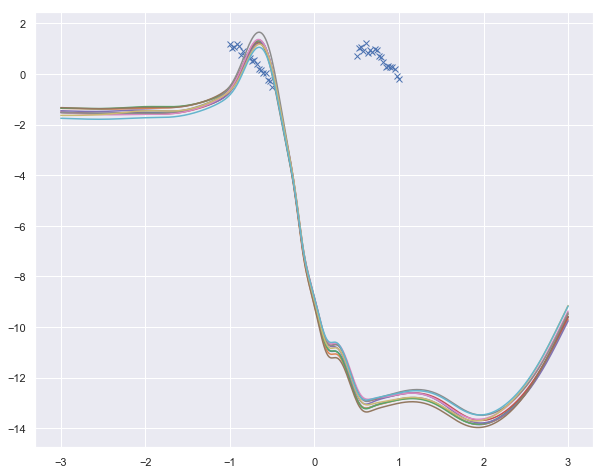

Iteration 50 lower bound -2201.720003298428


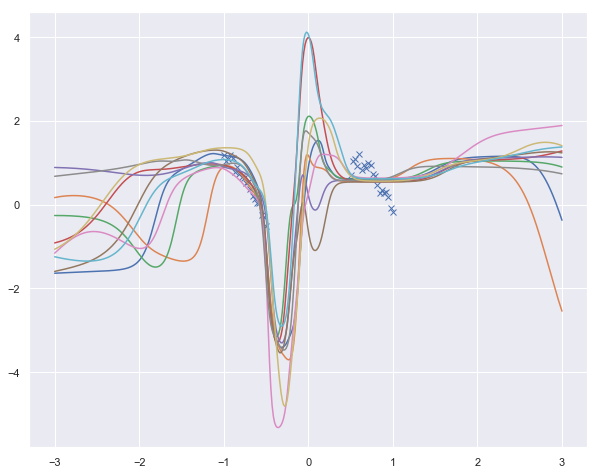

Iteration 100 lower bound -560.716512217722


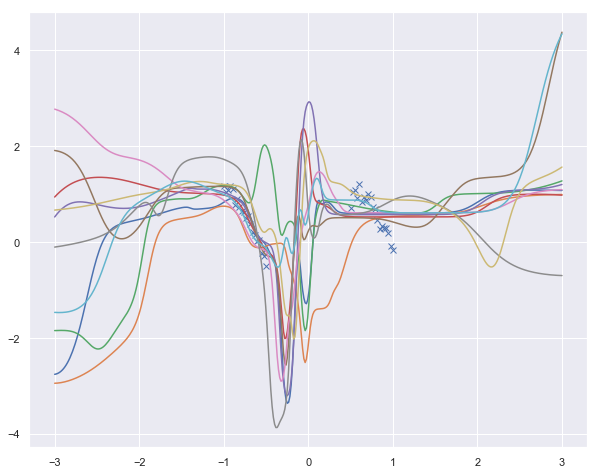

Iteration 150 lower bound 319.6526004895617


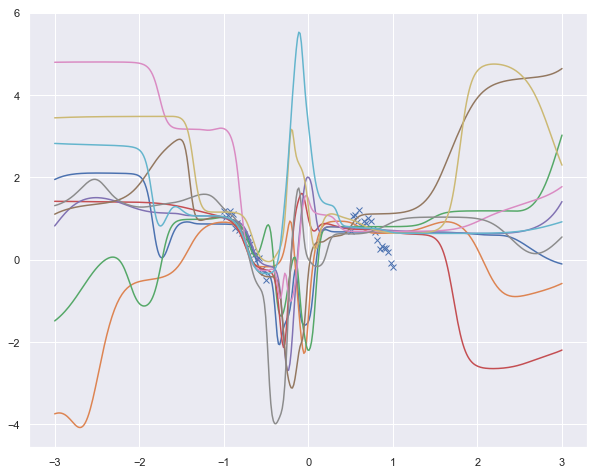

Iteration 200 lower bound 573.0432859207817


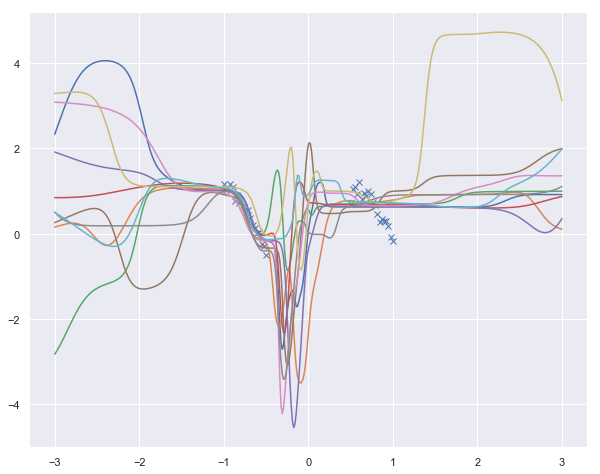

Iteration 250 lower bound 928.7886055948347


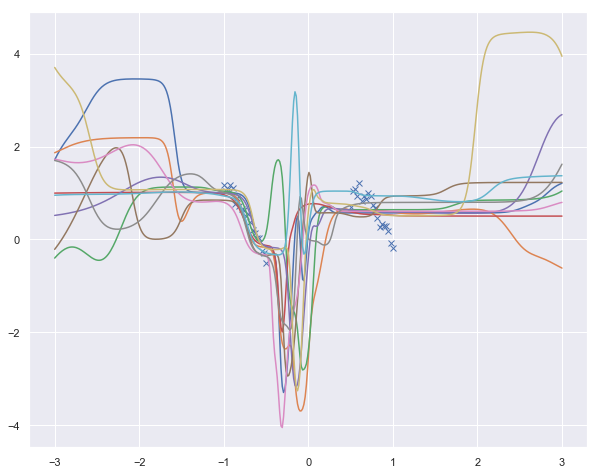

Iteration 300 lower bound 1127.3870124575867


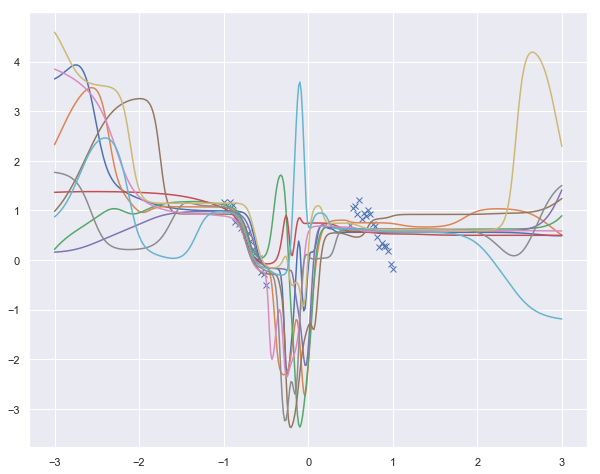

Iteration 350 lower bound 675.7072532418069


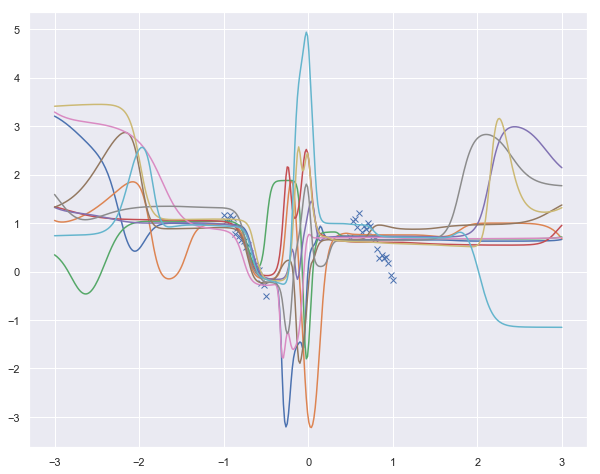

Iteration 400 lower bound 1187.8189283994245


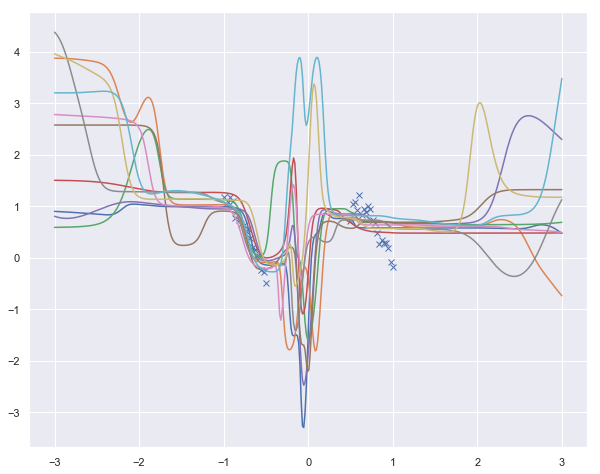

Iteration 450 lower bound 1298.8442705592188


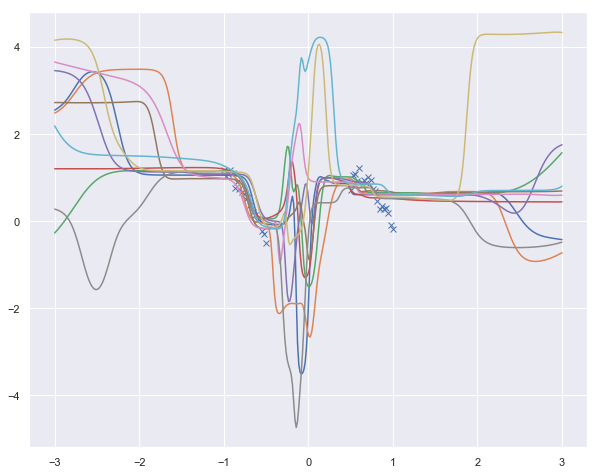

In [110]:
# Specify inference problem by its unnormalized log-posterior.
rbf = lambda x: np.exp(-x**2)
relu = lambda x: np.maximum(x, 0.)
num_weights, predictions, logprob = \
    make_nn_funs(layer_sizes=[1, 40, 40, 1], L2_reg=0.1,
                 noise_variance=0.01, nonlinearity=np.tanh)

inputs, targets = build_toy_dataset()
log_posterior = lambda weights, t: logprob(weights, inputs, targets)

# Build variational objective.
objective, gradient, unpack_params = \
    black_box_variational_inference_diagonal(log_posterior, num_weights,
                                    num_samples=20)

# Set up figure.
fig = plt.figure(figsize=(12, 8), facecolor='white')
# ax = fig.add_subplot(111, frameon=False)
# plt.ion()


def callback(params, t, g, inputs=inputs, targets=targets, ax=ax):
    if t % 50 == 0:
        print("Iteration {} lower bound {}".format(t, -objective(params, t)))

        # Sample functions from posterior.
        rs = npr.RandomState(0)
        mean, log_std = unpack_params(params)
        #rs = npr.RandomState(0)
        sample_weights = rs.randn(10, num_weights) * np.exp(log_std) + mean
        plot_inputs = np.linspace(-3, 3, num=400)
        outputs = predictions(sample_weights, np.expand_dims(plot_inputs, 1))

        # Plot data and functions.
        plt.figure(figsize=(10,8))
        plt.plot(inputs.ravel(), targets.ravel(), 'bx')
        plt.plot(plot_inputs, outputs[:, :, 0].T)
        ax.set_ylim([-2, 3])
        ax.set_xlim([-2, 2])
        plt.draw()
        plt.pause(1.0/60.0)

# Initialize variational parameters
rs = npr.RandomState(0)
init_mean    = rs.randn(num_weights)
init_log_std = -5 * np.ones(num_weights)
init_var_params = np.concatenate([init_mean, init_log_std])

print("Optimizing variational parameters...")
variational_params = adam(gradient, init_var_params,
                          step_size=0.1, num_iters=500, callback=callback)

# Variational Inference for a Neural Network for Classification

I adapted the above code to perform classification using a Bayesian neural network. Firstly, I create a data set using the `make_moons` function, which creates a nice linearly inseparable data set so that the neural network can flex its function approximation power. 

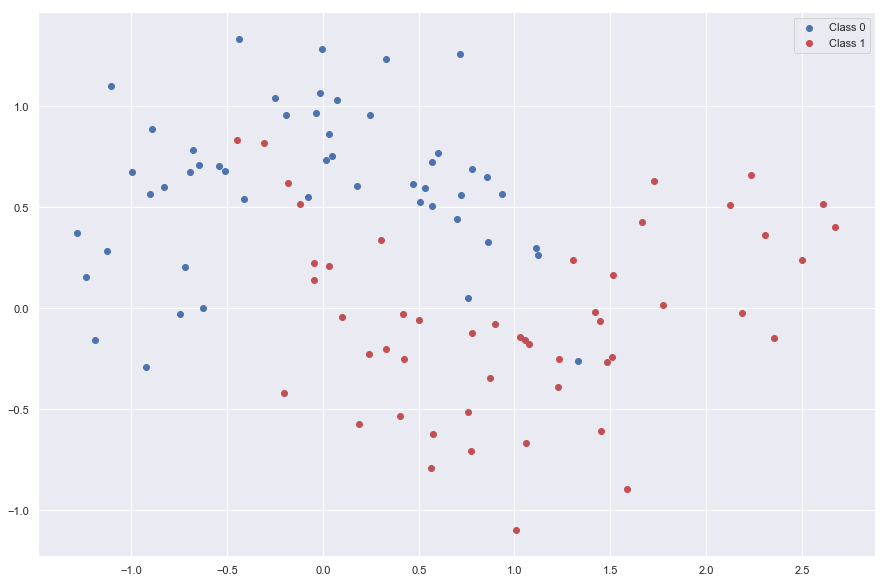

In [194]:
from scipy import stats
import seaborn as sns
from warnings import filterwarnings

import sklearn
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

filterwarnings('ignore')
sns.set_style('white')


cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
cmap_uncertainty = sns.cubehelix_palette(light=1, as_cmap=True)

sns.set()

X, Y = make_moons(noise=0.3, n_samples=100)
plt.figure(figsize=(15,10))
plt.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
plt.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); plt.legend();

I define a neural network similarly to the regression case. However, I add a sigmoid module onto the regression result to ensure that the outputs are between 0 and 1 and represent probabilities. The prior comes from the normal prior with fixed variance (representing the regularization term), and the likelihood comes from the log of the Bernoulli distribution, which also represents the binary cross-entropy loss function. I use the ReLU nonlinearity since it seems to work best.

In [246]:
def make_nn_funs(layer_sizes, L2_reg, noise_variance, nonlinearity=np.tanh):
    """These functions implement a standard multi-layer perceptron,
    vectorized over both training examples and weight samples."""
    shapes = list(zip(layer_sizes[:-1], layer_sizes[1:])) # define tensor shapes
    num_weights = sum((m+1)*n for m, n in shapes) # weights + bias term
    print(num_weights, shapes, [(m+1)*n for m, n in shapes])

    def unpack_layers(weights):
        num_weight_sets = len(weights)
        for m, n in shapes:
            yield weights[:, :m*n]     .reshape((num_weight_sets, m, n)),\
                  weights[:, m*n:m*n+n].reshape((num_weight_sets, 1, n))
            weights = weights[:, (m+1)*n:]

    def predictions(weights, inputs):
        """weights is shape (num_weight_samples x num_weights)
           inputs  is shape (num_datapoints x D)"""
        inputs = np.expand_dims(inputs, 0)
        for W, b in unpack_layers(weights):
            outputs = np.einsum('mnd,mdo->mno', inputs, W) + b
            inputs = nonlinearity(outputs)
        outputs = 1/(1 + np.exp(-outputs))
        return outputs

    def logprob(weights, inputs, targets):
        
        log_prior = -L2_reg * np.sum(weights**2, axis=1)
        preds = predictions(weights, inputs)
        preds = preds.reshape(preds.shape[:2])
        
        log_lik = np.sum(targets * np.log(preds + 1e-10) + (1 - targets) * np.log(1 - preds + 1e-10), axis = 1)
        return log_prior + log_lik

    return num_weights, predictions, logprob




    

In [227]:
def black_box_variational_inference(logprob, D, num_samples):
    """Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557"""

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        
        
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params

In [222]:
x = np.linspace(-2, 2, num=300)
y = np.linspace(-2, 2, num=300)
X_grid, Y_grid = np.meshgrid(x, y)


To perform variational inference on the model, I create the variational distribution and optimize the ELBO using `autograd`. To understand what the model is predicting, I sample from the variational distribution of parameters and take the mean of the predictions of these parameters. In the result, we can see the visualization of the model as it learns, as it shapes its decision boundary to better fit the data. In the decision boundary (white space), it appears that there is most variance here, as variational approximation is ambivalent as to the class of the data point. However, as pointed out by Wiecki, this is a capability that normal neural networks already have, which is mis-interpreted as the "confidence" of the model.

81 [(2, 20), (20, 1)] [60, 21]
Optimizing variational parameters...
Iteration 0 lower bound -818.7472064827108
Iteration 100 lower bound 38.21864442334876
Iteration 200 lower bound 51.538203572346134
Iteration 300 lower bound 44.28915467893009
Iteration 400 lower bound 50.65978853501451
Iteration 500 lower bound 54.53117121544637
Iteration 600 lower bound 53.64191462693306
Iteration 700 lower bound 51.79062066153698
Iteration 800 lower bound 31.13273127402762
Iteration 900 lower bound 51.575151981916065


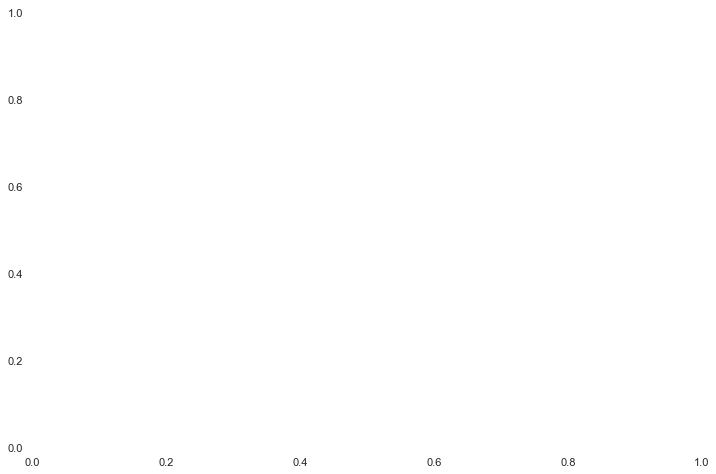

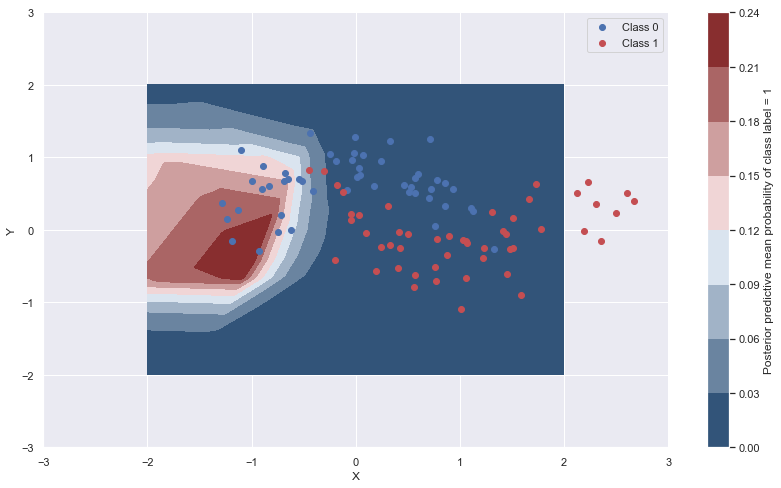

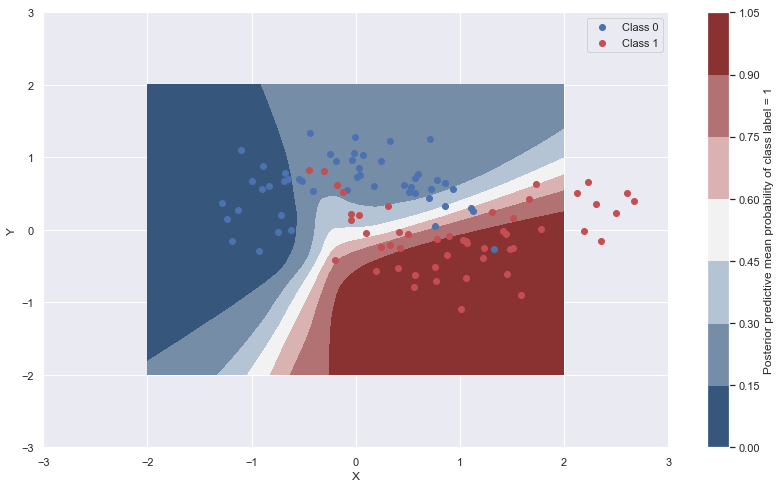

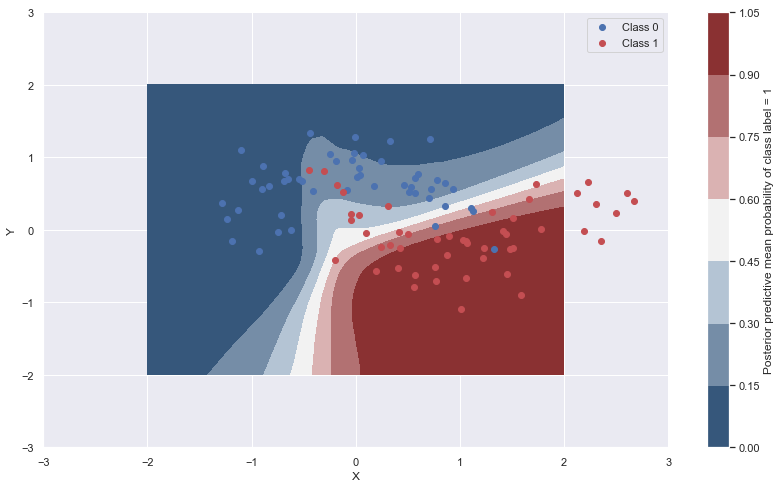

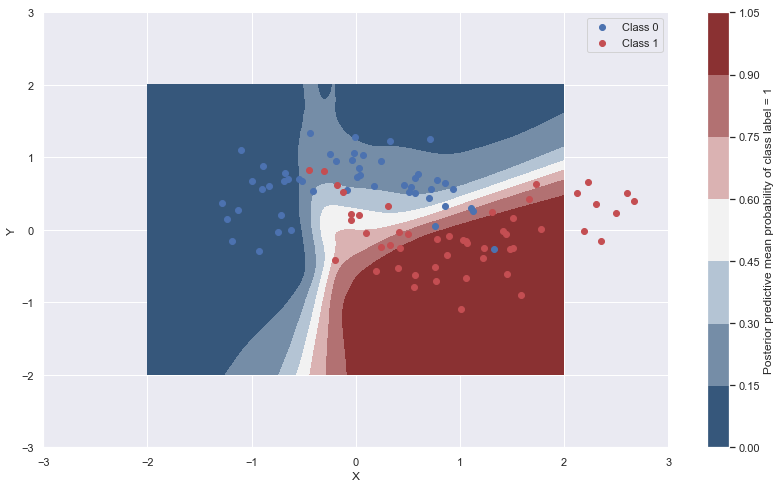

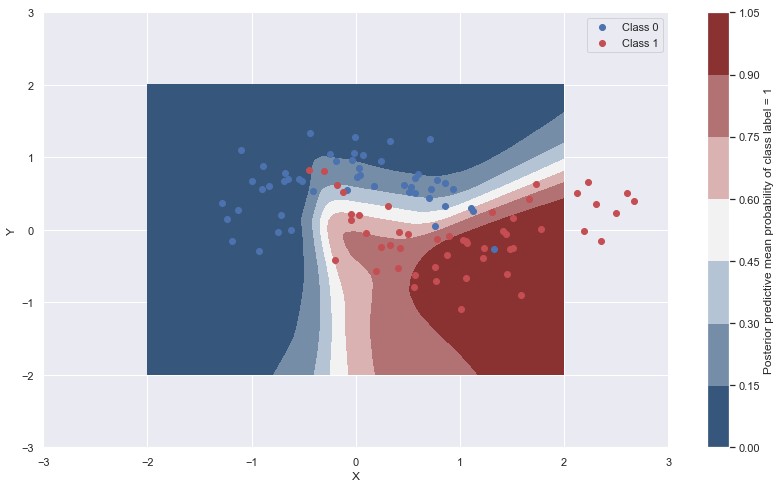

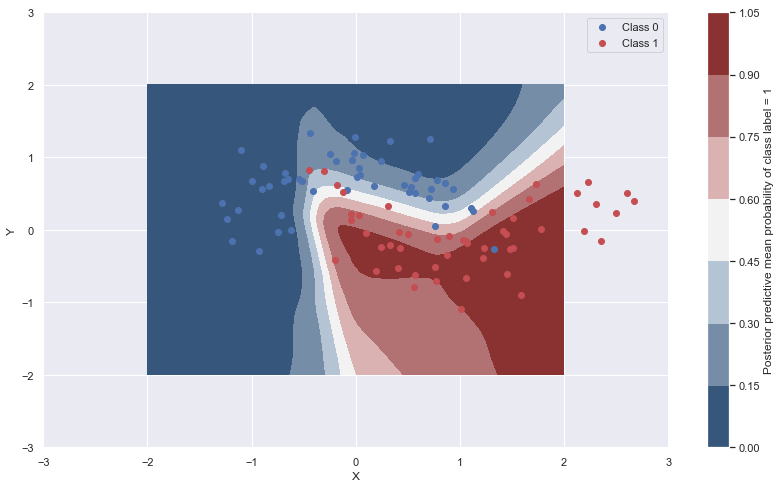

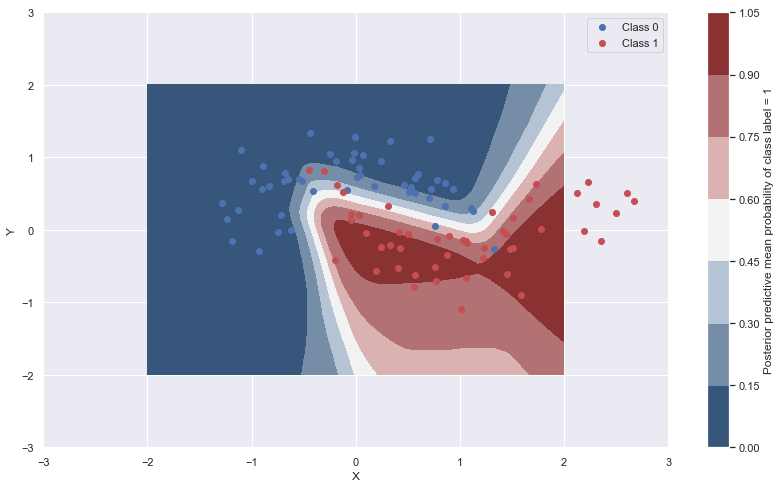

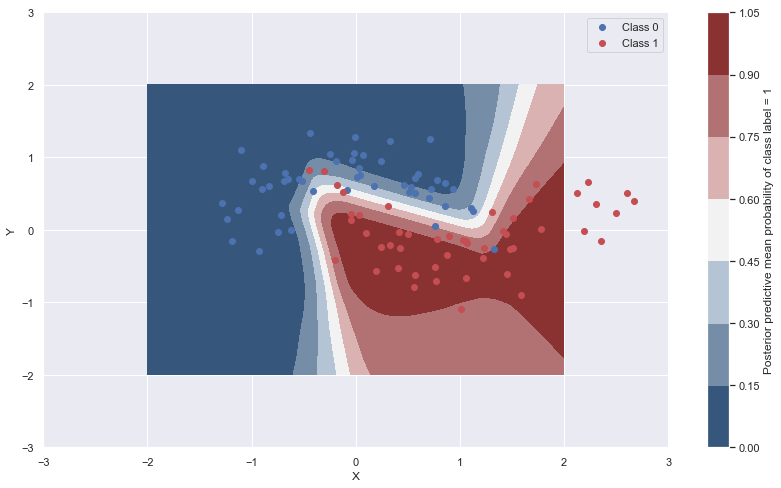

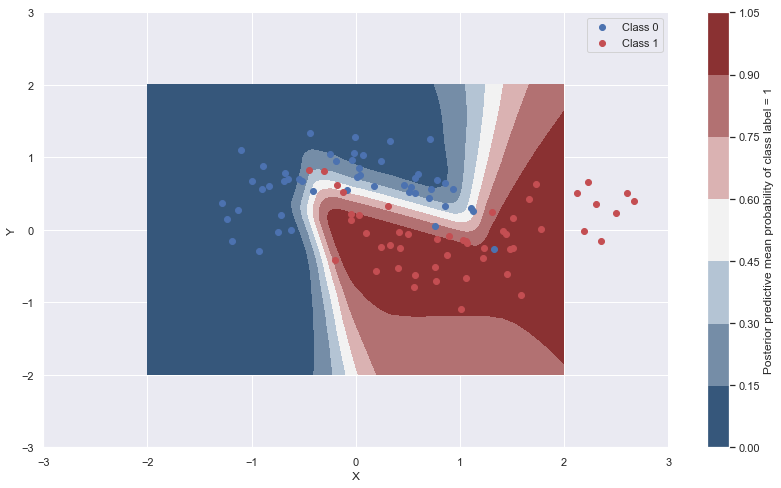

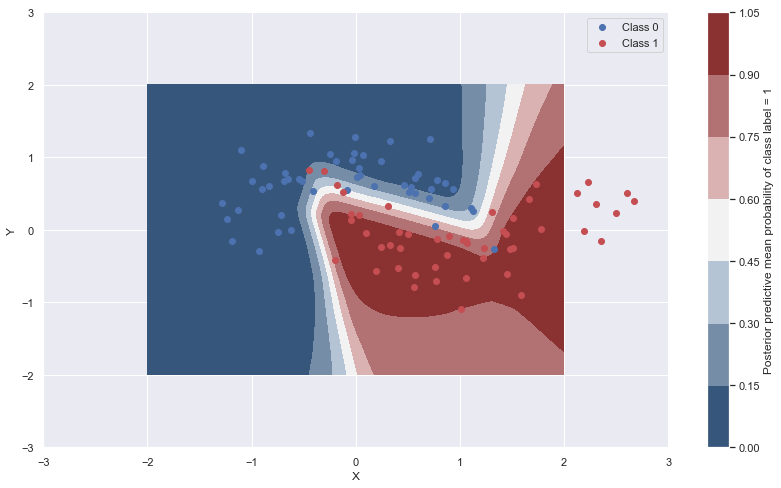

In [249]:
# Specify inference problem by its unnormalized log-posterior.
rbf = lambda x: np.exp(-x**2)
relu = lambda x: np.maximum(x, 0.)
sigmoid = lambda x: 1/(1+np.exp(-x))
num_weights, predictions, logprob = \
    make_nn_funs(layer_sizes=[2, 20, 1], L2_reg=0.1,
                 noise_variance=0.01, nonlinearity=relu)

inputs, targets = X, Y
log_posterior = lambda weights, t: logprob(weights, inputs, targets)

# Build variational objective.
objective, gradient, unpack_params = \
    black_box_variational_inference(log_posterior, num_weights,
                                    num_samples=20)




# Set up figure.
fig = plt.figure(figsize=(12, 8), facecolor='white')
ax = fig.add_subplot(111, frameon=False)
# plt.ion()


def callback(params, t, g, inputs=inputs, targets=targets, ax=ax):
    if t % 100 == 0:
        print("Iteration {} lower bound {}".format(t, -objective(params, t)))

        # Sample functions from posterior.
        rs = npr.RandomState(0)
        mean, log_std = unpack_params(params)
        #rs = npr.RandomState(0)
        sample_weights = rs.randn(50, num_weights) * np.exp(log_std) + mean

        x = np.linspace(-2, 2, num=300)
        y = np.linspace(-2, 2, num=300)
        X_grid, Y_grid = np.meshgrid(x, y)
        zs = predictions(sample_weights, np.concatenate((np.atleast_2d(X_grid.ravel()), np.atleast_2d(Y_grid.ravel()))).T)

        zs = np.mean(zs, axis = 0)
        Z = zs.reshape(X_grid.shape)

        cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)



        fig, ax = plt.subplots(figsize=(14, 8))
        contour = ax.contourf(X_grid, Y_grid, Z, cmap=cmap)
        cbar = plt.colorbar(contour, ax=ax)
        _ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
        cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 1');
        
        plt.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
        plt.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
        sns.despine(); plt.legend();
        
        plt.draw()


# Initialize variational parameters
rs = npr.RandomState(0)
init_mean    = rs.randn(num_weights)
init_log_std = -5 * np.ones(num_weights)
init_var_params = np.concatenate([init_mean, init_log_std])

print("Optimizing variational parameters...")
# objective(init_var_params, 1)
variational_params = adam(gradient, init_var_params,
                          step_size=0.1, num_iters=1000, callback=callback)

The innovation of Bayesian neural networks is in the posterior predictive distribution, which is formed by marginalizing out the parameters of the model. We are implicitly performing that marginalization by sampling from the variational posterior of each of the parameter and then forming a prediction based on that sample. By sampling 50 sets of weights from the model and predict using those weights, we can estimate the standard deviation of the posterior predictive distribution for each input point. We can see that the input points deep into the territory of each cluster have a posterior predictive distribution with low variance (blue), whereas the input points close to the boundary have higher variance (red). This gives us a sense of "uncertainty" of the model, which is the key innovation of Bayesian modelling.

Optimizing variational parameters...
Iteration 0 lower bound -818.6043159057052
Iteration 100 lower bound 43.18462505899093
Iteration 200 lower bound 46.683485374625945
Iteration 300 lower bound 46.00977392566527
Iteration 400 lower bound 51.23170774823845
Iteration 500 lower bound 46.357010020789374
Iteration 600 lower bound 47.473417543472465
Iteration 700 lower bound 53.13062589905803
Iteration 800 lower bound 54.7122111057111
Iteration 900 lower bound 50.428904198182536


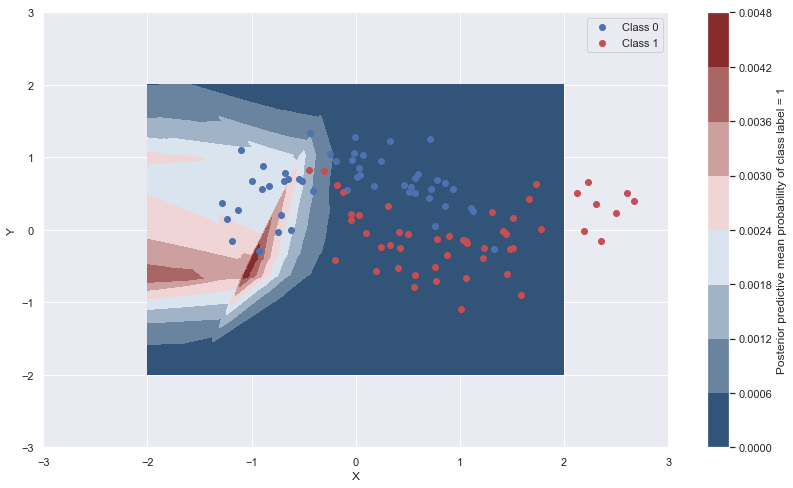

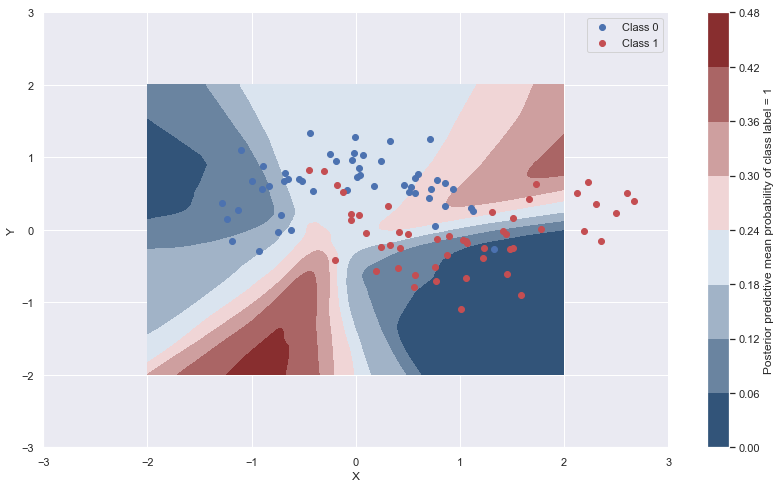

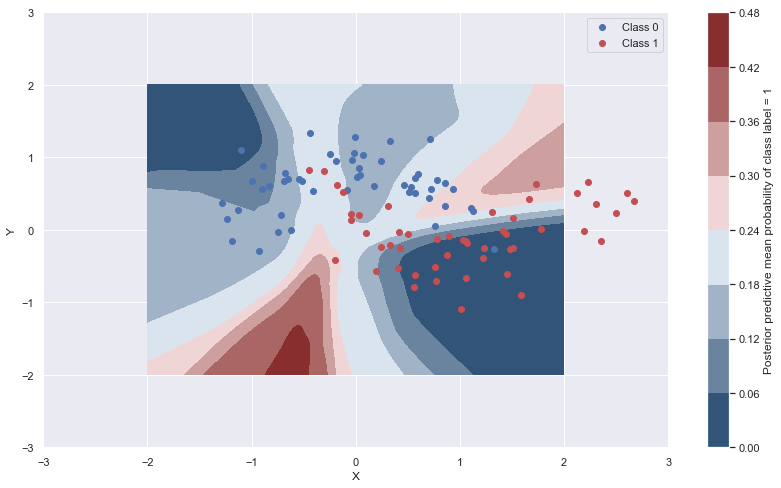

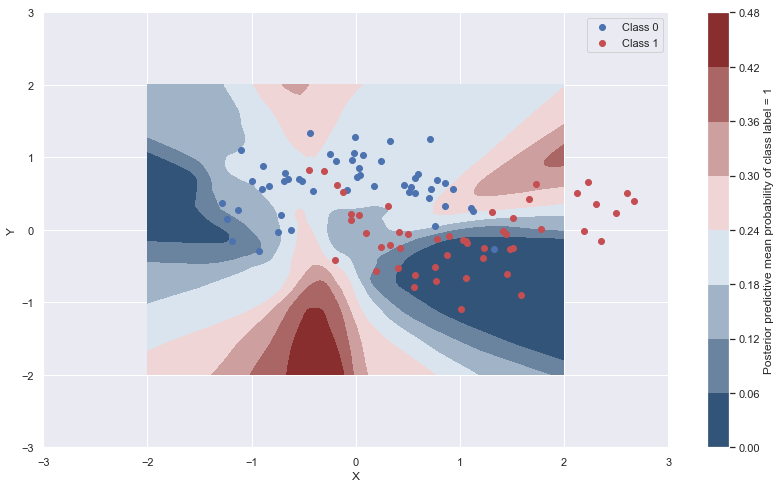

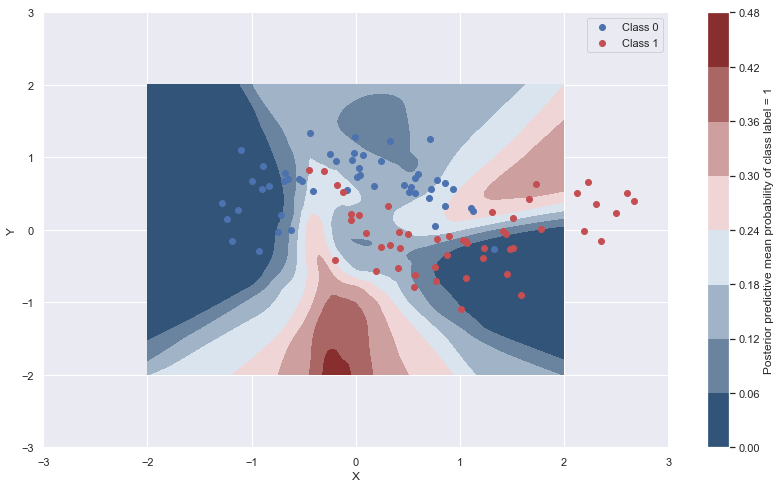

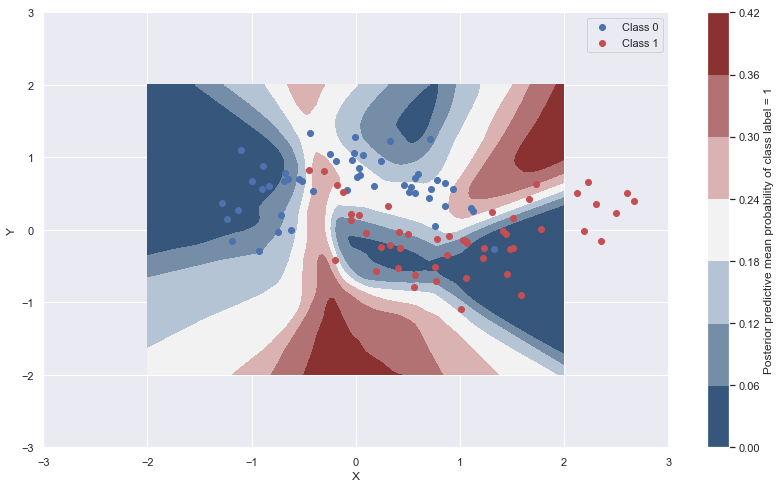

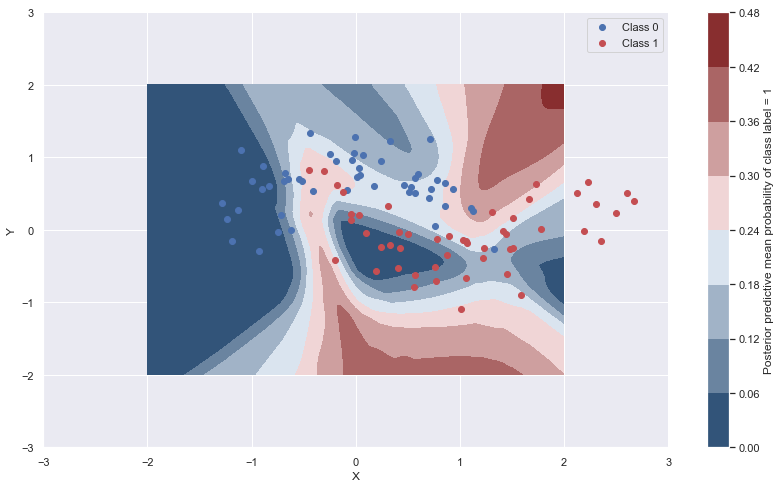

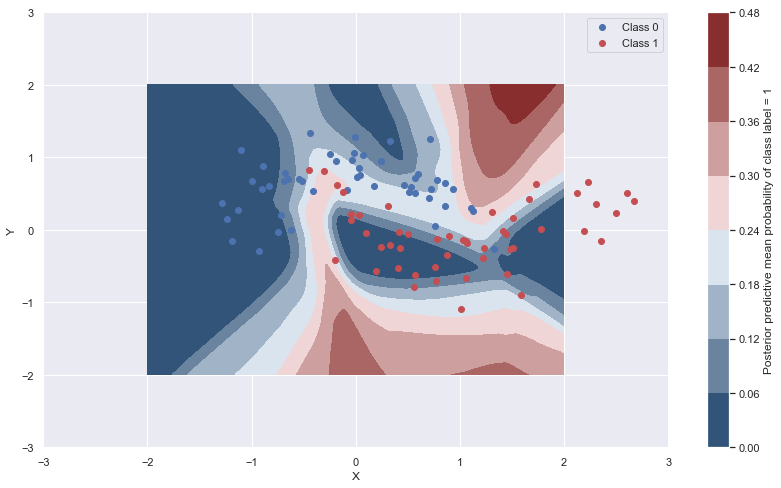

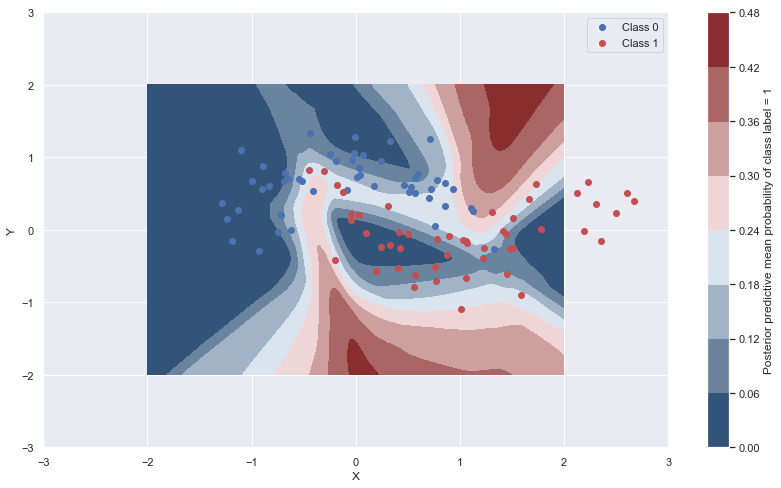

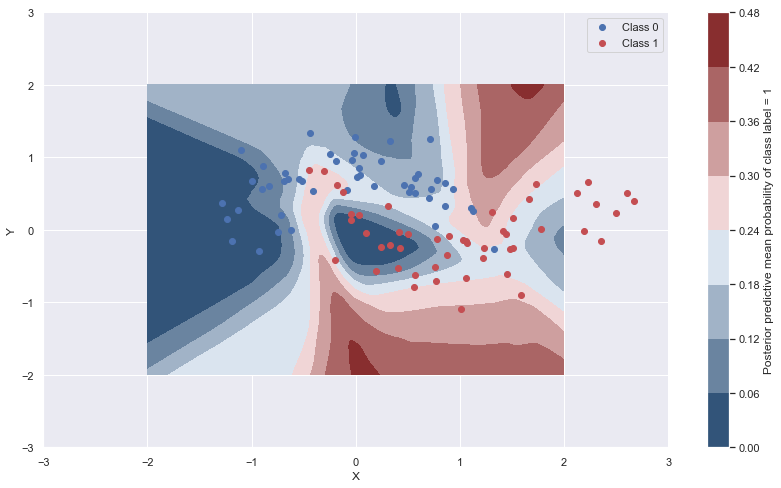

In [250]:
def callback(params, t, g, inputs=inputs, targets=targets, ax=ax):
    if t % 100 == 0:
        print("Iteration {} lower bound {}".format(t, -objective(params, t)))

        # Sample functions from posterior.
        rs = npr.RandomState(0)
        mean, log_std = unpack_params(params)
        #rs = npr.RandomState(0)
        sample_weights = rs.randn(50, num_weights) * np.exp(log_std) + mean

        x = np.linspace(-2, 2, num=300)
        y = np.linspace(-2, 2, num=300)
        X_grid, Y_grid = np.meshgrid(x, y)
        zs = predictions(sample_weights, np.concatenate((np.atleast_2d(X_grid.ravel()), np.atleast_2d(Y_grid.ravel()))).T)

        zs = np.std(zs, axis = 0)
        Z = zs.reshape(X_grid.shape)

        cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)



        fig, ax = plt.subplots(figsize=(14, 8))
        contour = ax.contourf(X_grid, Y_grid, Z, cmap=cmap)
        cbar = plt.colorbar(contour, ax=ax)
        _ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
        cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 1');
        
        plt.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
        plt.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
        sns.despine(); plt.legend();
        
        plt.draw()


# Initialize variational parameters
rs = npr.RandomState(0)
init_mean    = rs.randn(num_weights)
init_log_std = -5 * np.ones(num_weights)
init_var_params = np.concatenate([init_mean, init_log_std])

print("Optimizing variational parameters...")
# objective(init_var_params, 1)
variational_params = adam(gradient, init_var_params,
                          step_size=0.1, num_iters=1000, callback=callback)

References

[1] David Duvenaud, Ryan P. Adams. (2017). "Black-Box Stochastic Variational Inference in Five Lines of Python". Retrieved from https://arxiv.org/abs/1711.00165

[2] Thomas Wiecki. (2018). "Hierarchical Bayesian Neural Networks with Informative Priors". Retrieved from https://twiecki.github.io/blog/2018/08/13/hierarchical_bayesian_neural_network/